<a href="https://colab.research.google.com/github/ChelseaOwiti/Colposcopy-Scan/blob/main/draft4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%cd /content/drive/MyDrive/Project
%ls

/content/drive/MyDrive/Project
assets/      draft1.ipynb     imagenet_draft3_model.h5  model.tflite
d2_model.h5  draft1_model.h5  imagenet_model.h5         output/
d3_model.h5  draft2.ipynb     keras_metadata.pb         saved_model.pb
data/        h5_model.h5      logs/                     variables/


In [3]:
trainpath = 'data/train'
valpath = 'data/val'
testpath = 'data/test'

In [4]:
import numpy as np
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

import pathlib

In [5]:
train_dir = pathlib.Path(trainpath)
test_dir = pathlib.Path(valpath)

print(str(len(list(train_dir.glob('*/*.jpg'))) )+ ' Training Images')
print(str(len(list(test_dir.glob('*/*.jpg')))) + ' Testing Images')

888 Training Images
296 Testing Images


In [6]:
batch_size = 32  
img_height = 224
img_width = 224

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split = 0.1,
    subset ='training',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 888 files belonging to 3 classes.
Using 800 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split = 0.1,
    subset ='validation',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 888 files belonging to 3 classes.
Using 88 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['Type_1', 'Type_2', 'Type_3']


In [10]:
for image_batch, labels_batch in train_ds: #image batch is a tensor of the shape
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [11]:

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [12]:
normalization_layer = layers.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [14]:
num_classes = len(class_names)
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes= num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

94765736/94765736 [==============================] - 5s 0us/step


In [15]:
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.optimizers import Adam

In [16]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(5, activation='softmax'))

In [17]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 24,639,365
Trainable params: 1,051,653
Non-trainable params: 23,587,712
_________________________________________________________________


In [18]:
resnet_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=['accuracy'])



In [19]:
epochs = 10
history = resnet_model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=epochs)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


25/25 [==============================] - 35s 1s/step - loss: 2.0889 - accuracy: 0.4400 - val_loss: 1.3826 - val_accuracy: 0.3409
Epoch 2/10
25/25 [==============================] - 3s 109ms/step - loss: 0.9855 - accuracy: 0.5400 - val_loss: 1.2337 - val_accuracy: 0.4318
Epoch 3/10
25/25 [==============================] - 3s 108ms/step - loss: 0.8039 - accuracy: 0.6425 - val_loss: 1.1197 - val_accuracy: 0.4773
Epoch 4/10
25/25 [==============================] - 3s 109ms/step - loss: 0.6986 - accuracy: 0.7025 - val_loss: 1.0629 - val_accuracy: 0.5000
Epoch 5/10
25/25 [==============================] - 3s 110ms/step - loss: 0.6333 - accuracy: 0.7262 - val_loss: 1.1265 - val_accuracy: 0.5341
Epoch 6/10
25/25 [==============================] - 3s 109ms/step - loss: 0.5705 - accuracy: 0.7638 - val_loss: 1.1315 - val_accuracy: 0.4545
Epoch 7/10
25/25 [==============================] - 3s 109ms/step - loss: 0.5317 - accuracy: 0.7738 - val_loss: 1.3341 - val_accuracy: 0.3864
Epoch 8/10
25/25 [=

Model Evaluation

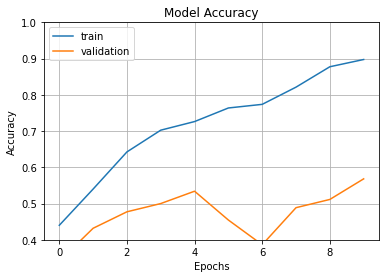

In [20]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

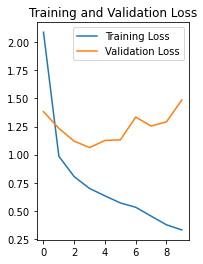

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predictions

In [22]:
#Type 1 Predictions
test_image = '/content/drive/MyDrive/Project/data/train/Type_1/1013.jpg'

img = tf.keras.utils.load_img(
    test_image, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = resnet_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 21ms/step
This image most likely belongs to Type_2 with a 27.62 percent confidence.


In [23]:
#Type 2
test_image = '/content/drive/MyDrive/Project/data/val/Type_2/1010.jpg'

img = tf.keras.utils.load_img(
    test_image, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = resnet_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 22ms/step
This image most likely belongs to Type_2 with a 37.89 percent confidence.


In [24]:
test_image = '/content/drive/MyDrive/Project/data/val/Type_3/1029.jpg'

img = tf.keras.utils.load_img(
    test_image, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = resnet_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 25ms/step
This image most likely belongs to Type_3 with a 35.44 percent confidence.


In [26]:
resnet_model.save("resnet50_model.h5")